## import os
import torch
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy import fft, fftpack
from scipy.ndimage import zoom
from random import randrange
import re
import importlib
import h5py

# Configure environment
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Jupyter inline plotting
%matplotlib inline

# Custom metrics
from metrics import calc_NRMSE as nrmse
from metrics import calc_SSIM as ssim

# Reconstruction utilities
from ulf_recon_fns import ulfl1recon, applyMask, poissonDiscSigpy, find_lamda_mask, find_iter_mask, coil_combine, awgn
import swin_fns
import automap_fns
import unrolling_fns

In [2]:


R = 4 # acceleration factor
calib_size = 10

loss_fn = 'mse'
#loss_fn = 'perceptual'

file_phantom_FS = 'data/volunteer_20240711/20240711_run4_QuadHeadCoil_95Litz_3D_64x75x25_TxOuter_FS_NA48_ActiveTxPlusBothRxs_HeadPhantom_GlobalShims.mat'
file_phantom_R2 = 'data/volunteer_20240711/20240711_run5_QuadHeadCoil_95Litz_3D_64x75x25_TxOuter_R2_NA48_ActiveTxPlusBothRxs_HeadPhantom_GlobalShims.mat'
file_phantom_R4 = 'data/volunteer_20240711/20240711_run6_QuadHeadCoil_95Litz_3D_64x75x25_TxOuter_R4_NA48_ActiveTxPlusBothRxs_HeadPhantom_GlobalShims.mat'

file_brain_FS = 'data/volunteer_20240711/20240711_run8_QuadHeadCoil_95Litz_3D_64x75x25_TxOuter_FS_NA64_ActiveTxPlusBothRxs_Head_GlobalShims.mat'
file_brain_R2 = 'data/volunteer_20240711/20240711_run9_QuadHeadCoil_95Litz_3D_64x75x25_TxOuter_R2_NA64_ActiveTxPlusBothRxs_Head_GlobalShims.mat'
file_brain_R4 = 'data/volunteer_20240711/20240711_run10_QuadHeadCoil_95Litz_3D_64x75x25_TxOuter_R4_NA64_ActiveTxPlusBothRxs_Head_GlobalShims.mat'


def ksp_load(filename):
    data = loadmat(filename)
    ksp_shp = data['i_kspace'].shape

    print(ksp_shp)
    
    if len(ksp_shp) > 3:
        ksp = np.moveaxis(data['i_kspace'],3,0)
    else:
        ksp = np.reshape(data['i_kspace'],(1,ksp_shp[0],ksp_shp[1],ksp_shp[2]))

    ksp = ksp[1,:,:,:]
    ksp = ksp[np.newaxis,:]

    return ksp   

In [3]:
def recon_prospective_us( ksp, R, recon_method = 'ifft', lamda_opt=0.001, iter_opt = 30):
    #scaling data

    img_rss = np.sum(np.abs(sp.ifft(ksp, axes=(-1, -2, -3)))**2, axis=0)**0.5
    volumeZFrss = img_rss
    
    # scaling all numbers to sensible values from the beginning
    scale_factor = np.percentile(abs(volumeZFrss),95) 
    kspZFscaled = ksp/scale_factor
    
    yshift = -2
    kspZFscaled = np.roll(kspZFscaled,(0,yshift,0),axis=(1,2,3))
    
    
    
    if kspZFscaled.shape[0] == 1:
        mps = np.ones(kspZFscaled.shape,dtype=complex)
    else:
        mps = mr.app.EspiritCalib(kspZFscaled, calib_width=20, kernel_width=6, show_pbar=True).run()
    #mps = np.ones(kspZFscaled.shape)
    img_fs = sp.ifft(kspZFscaled, axes=(-1, -2, -3))
    volumeZFscaled = coil_combine(img_fs,mps)

    #if R==1 or recon_method == 'zerofill':
        
    #else:
    mask = (np.abs(kspZFscaled[0,:,32,:]) > 0 )

    kspInput = kspZFscaled

    match recon_method:
        case 'ifft':
            return volumeZFscaled, scale_factor
        case 'cs':
            volcsrecon = ulfl1recon(kspInput,mask,lamda_opt,iter_opt,mps)
            return volcsrecon, scale_factor
        case 'automap':
            if R==2:
              model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_real_noise_bkgd_20240318/checkpoint/model.keras' #fast mri model
              model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_imag_noise_bkgd_20240318/checkpoint/model.keras'
            elif R==4:
              model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_real_noise_bkgd_20240328/checkpoint/model.keras' #fast mri model
              model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_imag_noise_bkgd_20240328/checkpoint/model.keras'
            volamaprecon, volamaprecon_mc = automap_fns.automapRecon(kspInput,mps,model_real_dir,model_imag_dir)
            volamaprecon = volamaprecon
            return volamaprecon, scale_factor
        case 'unrolled':
            if R==2:
                unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R2.pth'
            elif R==4:
                unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R4.pth'
            volunrollrecon = unrolling_fns.unrollingRecon(kspInput,mask,unroll_model_pth)
            return volunrollrecon, scale_factor
        case 'swincascade':
            if R==2:
                model_swin_pth = 'trained_models/SwinCascade/swincascade_model_best_R2.pth'
            elif R==4:
                model_swin_pth = 'trained_models/SwinCascade/swincascade_model_best_R4.pth'
            model_swin = swin_fns.load_swincascade_model(model_swin_pth, device=device)
            volswinrecon, _ = swin_fns.swinRecon(kspInput, mask, model_swin, device=device)
            return volswinrecon, scale_factor
 

In [4]:
# --- Phantom Reconstructions ---

# R = 1 (Fully sampled)
ksp = ksp_load(file_phantom_FS)
phantom_R1_GT, _ = recon_prospective_us(ksp, R=1, recon_method='ifft')

# R = 2
ksp = ksp_load(file_phantom_R2)
phantom_R2_zf, _ = recon_prospective_us(ksp, R=2, recon_method='ifft')
phantom_R2_cs, _ = recon_prospective_us(ksp, R=2, recon_method='cs', lamda_opt=0.001, iter_opt=30)
phantom_R2_amap, _ = recon_prospective_us(ksp, R=2, recon_method='automap')
phantom_R2_unroll, _ = recon_prospective_us(ksp, R=2, recon_method='unrolled')
phantom_R2_swin, _ = recon_prospective_us(ksp, R=2, recon_method='swincascade')

# R = 4
ksp = ksp_load(file_phantom_R4)
phantom_R4_zf, _ = recon_prospective_us(ksp, R=4, recon_method='ifft')
phantom_R4_cs, _ = recon_prospective_us(ksp, R=4, recon_method='cs', lamda_opt=0.001, iter_opt=30)
phantom_R4_amap, _ = recon_prospective_us(ksp, R=4, recon_method='automap')
phantom_R4_unroll, _ = recon_prospective_us(ksp, R=4, recon_method='unrolled')
phantom_R4_swin, _ = recon_prospective_us(ksp, R=4, recon_method='swincascade')


# --- Brain Reconstructions ---

# R = 1 (Fully sampled)
ksp = ksp_load(file_brain_FS)
brain_R1_GT, _ = recon_prospective_us(ksp, R=1, recon_method='ifft')

# R = 2
ksp = ksp_load(file_brain_R2)
brain_R2_zf, _ = recon_prospective_us(ksp, R=2, recon_method='ifft')
brain_R2_cs, _ = recon_prospective_us(ksp, R=2, recon_method='cs', lamda_opt=0.001, iter_opt=30)
brain_R2_amap, _ = recon_prospective_us(ksp, R=2, recon_method='automap')
brain_R2_unroll, _ = recon_prospective_us(ksp, R=2, recon_method='unrolled')
brain_R2_swin, _ = recon_prospective_us(ksp, R=2, recon_method='swincascade')

# R = 4
ksp = ksp_load(file_brain_R4)
brain_R4_zf, _ = recon_prospective_us(ksp, R=4, recon_method='ifft')
brain_R4_cs, _ = recon_prospective_us(ksp, R=4, recon_method='cs', lamda_opt=0.001, iter_opt=30)
brain_R4_amap, _ = recon_prospective_us(ksp, R=4, recon_method='automap')
brain_R4_unroll, _ = recon_prospective_us(ksp, R=4, recon_method='unrolled')
brain_R4_swin, _ = recon_prospective_us(ksp, R=4, recon_method='swincascade')


(75, 64, 25, 2)
(75, 64, 25, 2)


2025-10-20 15:53:16.807042: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-10-20 15:53:16.807071: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: autobeast
2025-10-20 15:53:16.807077: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: autobeast
2025-10-20 15:53:16.807128: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 575.64.3
2025-10-20 15:53:16.807149: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 575.64.3
2025-10-20 15:53:16.807154: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 575.64.3
/home/david/repos/lowfieldrecon/LowFieldReconPrivate/.venvkerasandtf/lib/python3.10/site-packages/torch/functional.py:554: UserWarnin

(75, 64, 25, 2)
(75, 64, 25, 2)
(75, 64, 25, 2)
(75, 64, 25, 2)


In [5]:
# --- Phantom grouped reconstructions ---
phantom_vols_R2 = [
    phantom_R1_GT,    # GT for R=2 comparisons
    phantom_R2_zf,
    phantom_R2_cs,
    phantom_R2_amap,
    phantom_R2_unroll,
    phantom_R2_swin
]

phantom_vols_R4 = [
    None,             # No GT for R=4
    phantom_R4_zf,
    phantom_R4_cs,
    phantom_R4_amap,
    phantom_R4_unroll,
    phantom_R4_swin
]

# --- Brain grouped reconstructions ---
brain_vols_R2 = [
    brain_R1_GT,      # GT for R=2 comparisons
    brain_R2_zf,
    brain_R2_cs,
    brain_R2_amap,
    brain_R2_unroll,
    brain_R2_swin
]

brain_vols_R4 = [
    None,             # No GT for R=4
    brain_R4_zf,
    brain_R4_cs,
    brain_R4_amap,
    brain_R4_unroll,
    brain_R4_swin
]


In [6]:
# Apply mask to a list of volumes
def apply_mask_to_volumes(volumes, mask):
    for i in range(len(volumes)):
        if volumes[i] is not None:
            volumes[i][mask] = 0

# Generate the mask from the GT (which is index 0 in each R=2 list)
phantom_mask = np.ma.getmask(np.ma.masked_less(np.abs(phantom_vols_R2[0]), 0.17))
brain_mask   = np.ma.getmask(np.ma.masked_less(np.abs(brain_vols_R2[0]), 0.15))

# Apply the masks
apply_mask_to_volumes(phantom_vols_R2, phantom_mask)
apply_mask_to_volumes(phantom_vols_R4, phantom_mask)

apply_mask_to_volumes(brain_vols_R2, brain_mask)
apply_mask_to_volumes(brain_vols_R4, brain_mask)


In [7]:
def plot_recons_both(axs, GT_phantom, vols_R2_phantom, vols_R4_phantom,
                     GT_brain, vols_R2_brain, vols_R4_brain,
                     titles, slc_phantom, slc_brain, asp_ratio, max_GT_phantom, max_GT_brain):

    for col in range(len(titles)):
        # Phantom R=2
        axs[0, col].imshow(np.abs(vols_R2_phantom[col][:, :, slc_phantom].T), cmap='gray',
                           vmin=0, vmax=1.05 * max_GT_phantom)
        
        if col == 0:
            axs[0, col].set_title(f'(a) {titles[col]}', fontweight='bold')
            axs[2, col].set_title(f'(b) {titles[col]}', fontweight='bold')
        else:
            axs[0, col].set_title(titles[col], fontweight='bold')
            axs[2, col].set_title(titles[col], fontweight='bold')
        axs[0, col].set_aspect(asp_ratio)
        axs[0, col].set_xticks([])
        axs[0, col].set_yticks([])
        if col > 0:
            axs[0, col].set_xlabel(f'SSIM* = {ssim(np.abs(vols_R2_phantom[col]), np.abs(GT_phantom)):.2f}\n'
                                   f'NRMSE* = {nrmse(np.abs(vols_R2_phantom[col]), np.abs(GT_phantom)):.3f}')
            if col == 1:
                axs[0, col].set_ylabel('R = 2', fontsize=11, fontweight='bold')
        #else:
            #axs[0, col].set_ylabel('Phantom', fontsize=11, fontweight='bold')

        # Phantom R=4
        if col > 0:
            axs[1, col].imshow(np.abs(vols_R4_phantom[col][:, :, slc_phantom].T), cmap='gray',
                               vmin=0, vmax=1.05 * max_GT_phantom)
            axs[1, col].set_aspect(asp_ratio)
            axs[1, col].set_xticks([])
            axs[1, col].set_yticks([])
            axs[1, col].set_xlabel(f'SSIM* = {ssim(np.abs(vols_R4_phantom[col]), np.abs(GT_phantom)):.2f}\n'
                                   f'NRMSE* = {nrmse(np.abs(vols_R4_phantom[col]), np.abs(GT_phantom)):.3f}')
            if col == 1:
                axs[1, col].set_ylabel('R = 4', fontsize=11, fontweight='bold')

        # Brain R=2
        axs[2, col].imshow(np.abs(vols_R2_brain[col][:, :, slc_brain].T), cmap='gray',
                           vmin=0, vmax=1.05 * max_GT_brain)
        axs[2, col].set_aspect(asp_ratio)
        axs[2, col].set_xticks([])
        axs[2, col].set_yticks([])
        if col > 0:
            axs[2, col].set_xlabel(f'SSIM* = {ssim(np.abs(vols_R2_brain[col]), np.abs(GT_brain)):.2f}\n'
                                   f'NRMSE* = {nrmse(np.abs(vols_R2_brain[col]), np.abs(GT_brain)):.3f}')
            if col == 1:
                axs[0, col].set_ylabel('R = 2', fontsize=11, fontweight='bold')
        #else:
            #axs[2, col].set_ylabel('Brain', fontsize=11, fontweight='bold')

        # Brain R=4
        if col > 0:
            axs[3, col].imshow(np.abs(vols_R4_brain[col][:, :, slc_brain].T), cmap='gray',
                               vmin=0, vmax=1.05 * max_GT_brain)
            axs[3, col].set_aspect(asp_ratio)
            axs[3, col].set_xticks([])
            axs[3, col].set_yticks([])
            axs[3, col].set_xlabel(f'SSIM* = {ssim(np.abs(vols_R4_brain[col]), np.abs(GT_brain)):.2f}\n'
                                   f'NRMSE* = {nrmse(np.abs(vols_R4_brain[col]), np.abs(GT_brain)):.3f}')
            if col == 1:
                axs[3, col].set_ylabel('R = 4', fontsize=11, fontweight='bold')

    axs[1, 0].axis('off')
    axs[3, 0].axis('off')

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect(asp_ratio)
        ax.tick_params(color='k')
        for spine in ax.spines.values():
            spine.set_edgecolor('k')


    shift_down = -0.03  # adjust this value as needed
    
    for k in range(len(titles)):
        for j in [2, 3]:  # rows 2 and 3
            l, b, w, h = axs[j, k].get_position().bounds
            axs[j, k].set_position([l, b - shift_down, w, h])



    return axs


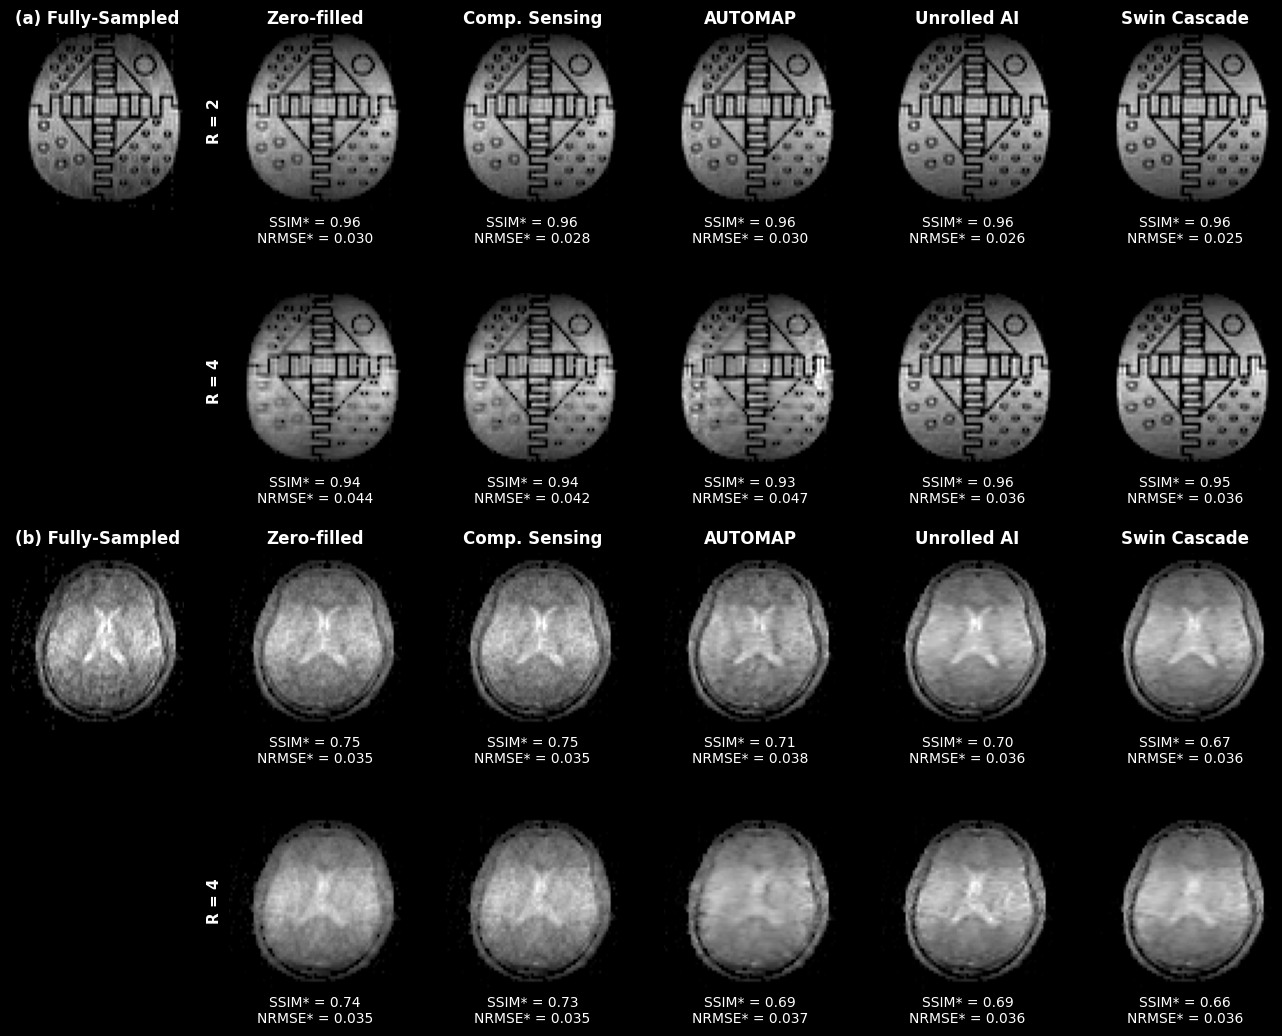

In [9]:
# --- Setup shared titles and volume arrays ---
titles = ['Fully-Sampled', 'Zero-filled', 'Comp. Sensing', 'AUTOMAP', 'Unrolled AI', 'Swin Cascade']
asp_ratio = (phantom_R4_zf.shape[1] * 3.5) / (phantom_R4_zf.shape[0] * 2.5)

slc_phantom=16
slc_brain=17
max_GT_phantom = np.amax(np.abs(phantom_R4_zf[:, :, slc_phantom]))
max_GT_brain = np.amax(np.abs(brain_R4_zf[:, :, slc_brain]))

plt.style.use('dark_background')
fig, axs = plt.subplots(4, 6, figsize=(13, 10))
axs = plot_recons_both(axs,
                       phantom_R1_GT, phantom_vols_R2, phantom_vols_R4,
                       brain_R1_GT, brain_vols_R2, brain_vols_R4,
                       titles, slc_phantom, slc_brain,
                       asp_ratio, max_GT_phantom, max_GT_brain)


plt.tight_layout()
plt.show()

fig.savefig('export_figs/prospective_ulf_recon.pdf', bbox_inches='tight', dpi=300)

In [37]:
ksp_fs_ph = ksp_load(file_phantom_FS)
vol_fs_ph, _ = recon_prospective_us(ksp_fs_ph, R=1, recon_method='ifft')
vol_fs_ph_mag = np.abs(vol_fs_ph).astype(np.float64)

ksp_fs_br = ksp_load(file_brain_FS)
vol_fs_br, _ = recon_prospective_us(ksp_fs_br, R=1, recon_method='ifft')
vol_fs_br_mag = np.abs(vol_fs_br).astype(np.float64)

(75, 64, 25, 2)
(75, 64, 25, 2)


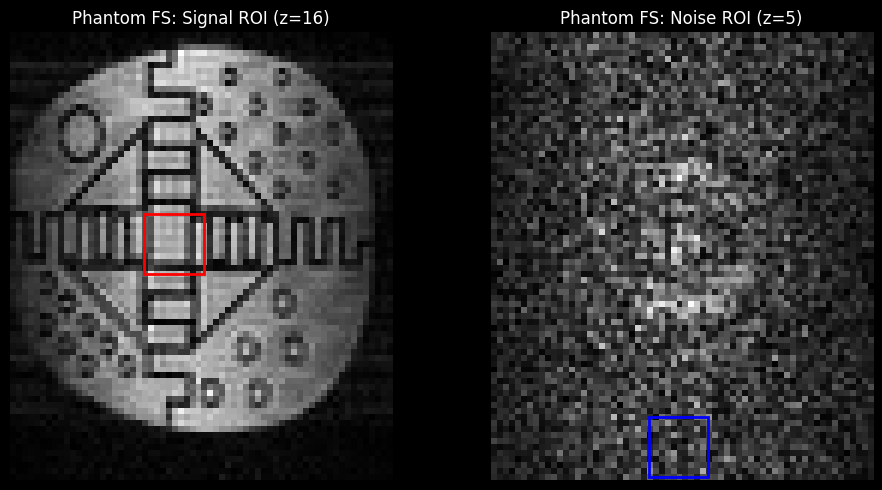

Phantom SNR: 22.74 (27.14 dB)


In [46]:
from snr_calc import snr_from_volume

# assuming vol_fs_ph_mag is your magnitude volume (np.ndarray)
snr_lin, snr_db, sig_mean, noi_std, sig_org, noi_org = snr_from_volume(
    vol_fs_ph_mag,
    cube_size=10,
    signal_origin=(34, 22, 11),  # or None for centered cube
    noise_origin=(0, 26, 0),
    plot=True,
    dataset_name="Phantom FS"
)

print(f"Phantom SNR: {snr_lin:.2f} ({snr_db:.2f} dB)")

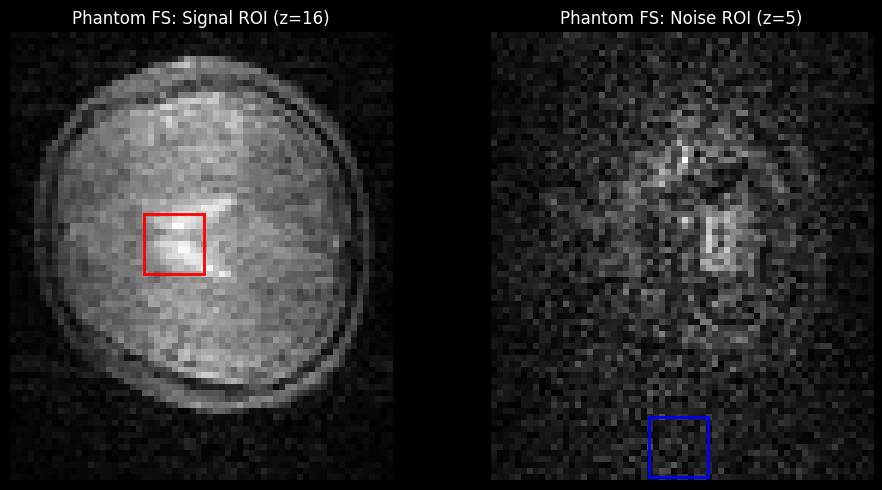

Brain SNR: 19.09 (25.62 dB)


In [48]:

snr_lin, snr_db, sig_mean, noi_std, sig_org, noi_org = snr_from_volume(
    vol_fs_br_mag,
    cube_size=10,
    signal_origin=(34, 22, 11),  # or None for centered cube
    noise_origin=(0, 26, 0),
    plot=True,
    dataset_name="Phantom FS"
)

print(f"Brain SNR: {snr_lin:.2f} ({snr_db:.2f} dB)")